<a href="https://colab.research.google.com/github/roderickperez/PINN/blob/master/PINN_Tutorial1_ApproxFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN

Tutorial 1: Approximate Function | Juan Toscano (Github: jdtoscano94)

https://github.com/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/1_Approximate_a_function.ipynb

## 0. Install Libraries

In [36]:
! pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Import Libraries

In [37]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

## 2. Setup parameters and constants

In [39]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda


In [116]:
# Parameters

steps = 50
lr = 0.01
n_control_points = 100

## 3. Define Function

In [117]:
def f(x):
    y=torch.sin(x)
    return y

## 4. Define Network Architecture

Following the PyTorch Network Architecture
```python
class networkName(nn.Module):

    def __init__(self, ...):
        super(networkName, self).__init__()
        # Define Network layers
        self.layer1 = nn.XXXX(...)
        self.layer2 = nn.XXXX(...)
        ...
        self.layern = nn.XXXX(...)

    def forward(self, x):
        out = self.layer1
        out = self.layer2
        ...
        out = self.layern

        return out

# Call the model
model = networkName(...)

# Define loss
loss = nn.XXXLoss()
```

In this case, we will follow the following architecture:

*   Activation Function: tanh
*   Loss Function: MSE
*   Initialise neural network as a list using `nn.Modulelist()`



In [118]:
class FCN(nn.Module):
    
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1): 
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    # Foward pass
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)         
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    # Define Loss Function
    def lossNN(self,x,y):
      loss_val=self.loss_function(self.forward(x),y)
      return loss_val

    def closure(self):
        optimizer.zero_grad()
        loss = self.lossNN(x_train, y_train)
        loss.backward()       
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss

## 5. Data

Generate the analytical solution over the full domain

In [119]:
x = torch.linspace(0,2*np.pi,n_control_points).view(-1,1) #prepare to NN
y = f(x)
print(x.shape, y.shape)

torch.Size([100, 1]) torch.Size([100, 1])


### 5.1 Plot Results

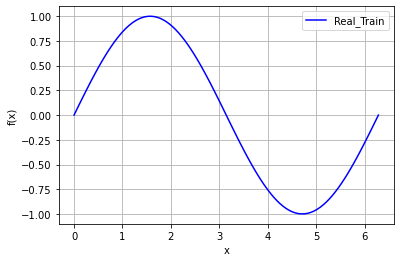

In [120]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper right')

### 5.2 Split data

In [121]:
indices=np.arange(n_control_points)

In [122]:
len(indices)

100

In [123]:
train_idx, test_idx, _ , _ = train_test_split(indices, indices, test_size=0.4, random_state=42)

In [124]:
x_train = x[train_idx]
y_train = y[train_idx]
x_test = x[test_idx]
y_test = y[test_idx]

In [125]:
print('x_train size = ', len(x_train))
print('y_train size = ', len(y_train))
print('x_test size = ', len(x_test))
print('y_test size = ', len(y_test))

x_train size =  60
y_train size =  60
x_test size =  40
y_test size =  40


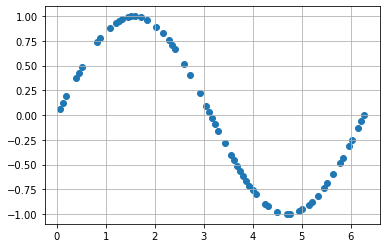

In [126]:
plt.scatter(x_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())
plt.grid()

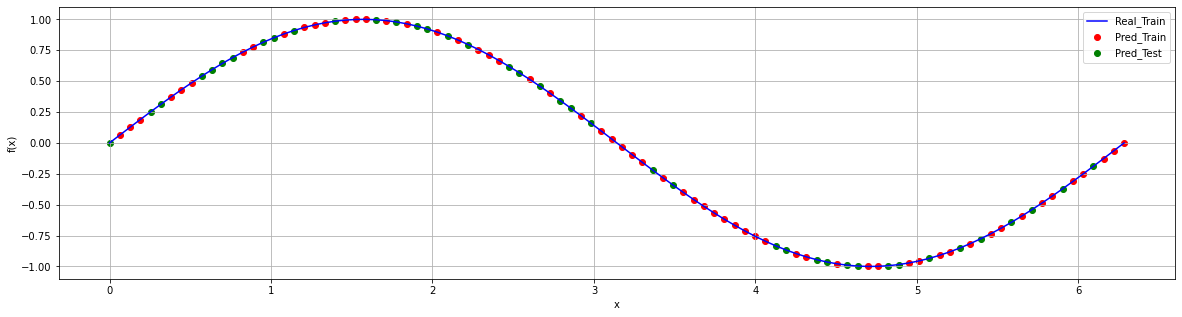

In [127]:
fig, ax1 = plt.subplots(figsize = [20, 5])
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.scatter(x_train.detach().cpu().numpy(),y_train.detach().cpu().numpy(),color='red',label='Train')
ax1.scatter(x_test.detach().cpu().numpy(),y_test.detach().cpu().numpy(),color='green',label='Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper right')

## 6. Train Network

In [128]:
# Prepare model
torch.manual_seed(123)
x_train=x_train.float().to(device)
y_train=y_train.float().to(device)
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers

In [129]:
# Model Summary
model = FCN(layers)
print(model)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [130]:
model.to(device)

params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

### 6.1 Training Loop

In [131]:
l = []

for i in range(steps):
    optimizer.zero_grad()
    yh = model(x_train)
    loss = model.lossNN(x_train,y_train)# use mean squared error
    l.append(loss.item())
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(0.6361, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5262, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3733, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2296, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1124, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0953, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0770, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0751, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<MseLossBackward0>)


## 6. Accuracy

In [132]:
print(model.lossNN(x_test.float().to(device),y_test.float().to(device)))

tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)


In [133]:
yh = model(x_train)
yh_test = model(x_test.float().to(device))

In [134]:
_ , indices2 = torch.sort(x_train.squeeze(1))
_ , indices3 = torch.sort(x_test.squeeze(1))

In [135]:
x_train_plot = x_train[indices2]
y_train_plot = y_train[indices2]
yh_plot = yh[indices2]
x_test_plot = x_test[indices3]
y_test_plot = y_test[indices3]
yh_test_plot = yh_test[indices3] 

## 7. Plot Results

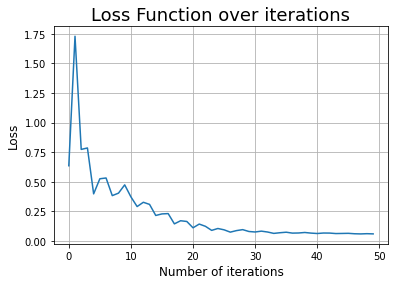

In [136]:
plt.plot(l)
plt.xlabel('Number of iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss Function over iterations', fontsize = 18)
plt.grid()

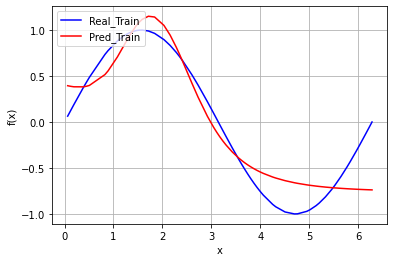

In [137]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot.detach().cpu().numpy(),y_train_plot.detach().cpu().numpy(),color='blue',label='Real_Train')
ax1.plot(x_train_plot.detach().cpu().numpy(),yh_plot.detach().cpu().numpy(),color='red',label='Pred_Train')
#ax1.plot(x_test_plot.detach().numpy(),y_test_plot.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_test_plot.detach().numpy(),yh_test_plot.detach().numpy(),color='orange',label='Pred_Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.grid()
ax1.legend(loc = 'upper left')

In [138]:
torch.max(x_train)

tensor(6.2832, device='cuda:0')

In [144]:
print('x_train size = ', len(x_train))
print('y_train size = ', len(y_train))
print('x_test size = ', len(x_test))
print('y_test size = ', len(y_test))

x_train size =  60
y_train size =  60
x_test size =  40
y_test size =  40


In [145]:
print('x_train_plot size = ', len(x_train_plot))
print('y_train_plot size = ', len(y_train_plot))


x_train_plot size =  60
y_train_plot size =  60


In [146]:
print('yh_test size = ', len(yh_test))

yh_test size =  40


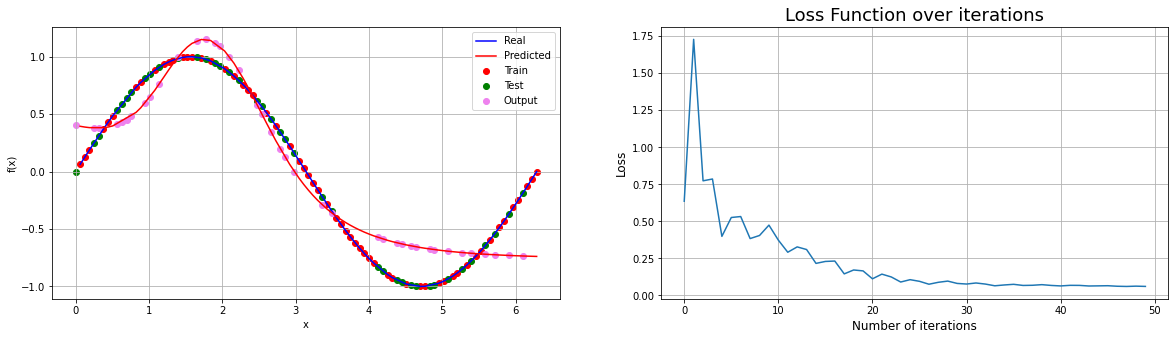

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(x_train_plot.detach().cpu().numpy(),y_train_plot.detach().cpu().numpy(),color='blue',label='Real')
ax1.plot(x_train_plot.detach().cpu().numpy(),yh_plot.detach().cpu().numpy(),color='red',label='Predicted')

ax1.scatter(x_train.detach().cpu().numpy(),y_train.detach().cpu().numpy(),color='red',label='Train')
ax1.scatter(x_test.detach().cpu().numpy(),y_test.detach().cpu().numpy(),color='green',label='Test')

ax1.scatter(x_test.detach().cpu().numpy(),yh_test.detach().cpu().numpy(),color='violet',label='Output')

ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')
ax1.grid()

##############
ax2.plot(l)
ax2.set_xlabel('Number of iterations', fontsize = 12)
ax2.set_ylabel('Loss', fontsize = 12)
ax2.set_title('Loss Function over iterations', fontsize = 18)
ax2.grid()